# 1. PV Prediction

このチュートリアルでは、BERT を使用してニュース記事のタイトルを元にクリック率を予測するモデルを構築します。

この Notebook の前半はある程度大きなデータセットを処理するためメモリの大きいインスタンスを利用することを推奨します。このノートブックの前半は SageMaker Studio Notebook の m5.4xlarge インスタンスで検証しました。

この Notebook の後半は BERT の学習を実行するため GPU インスタンスを利用することを推奨します。このノートブックの後半は SageMaker Studio Notebook の g5.2xlarge インスタンスで検証しました。

## Dataset Preparation

まずデータセットの用意をします。今回は記事データと PV 数があるサンプルデータセットとして Microsoft が公開しているニュースレコメンド向けの非商用データセットである [Microsoft News Dataset (MIND)](https://msnews.github.io/) データセットを使用します。

このデータセットは Microsoft News のクリック率のデータです。Microsoft News ではニュース記事の画像とタイトルを並べて表示しているため、画像・タイトル・表示位置などがクリック率に影響すると想定されます。データセットに含まれているのはタイトルのみのため、タイトルのみでどの程度クリックを予測できるのか検証します。


まず、今回はタイトルから PV 数を予測するモデルを構築するため、記事データ + PV 数にデータを整形します。

必要なのはタイトルと PV 数だけなので適宜自社データに置き換えてください。

In [2]:
# Download Dataset

# 5 万人分の小規模データ
# !wget https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
# !unzip MINDsmall_train.zip -d dataset
# !rm MINDsmall_train.zip

# 100 万人分の大規模データ（article_pv.csv はこちらを処理したもの
# !wget https://mind201910small.blob.core.windows.net/release/MINDlarge_train.zip
# !unzip MINDlarge_train.zip -d dataset
# !rm MINDlarge_train.zip

In [3]:
import pandas as pd
import os

output_path = "article_pv.csv"

# データが前処理済みであれば処理済みデータを使用する
if os.path.exists(output_path):
    result = pd.read_csv(output_path)
else:
    news_df = pd.read_csv('dataset/news.tsv', sep='\t',
                          names=["News ID", "Category", "Subcategory", "Title", 
                                   "Abstract", "URL", "Title Entities", "Abstract Entities"])
    behavior_df = pd.read_csv('dataset/behaviors.tsv', sep='\t',
                              names=["Impression ID", "User ID", "Time", "History", "Impressions"])


    # ユーザーの行動データから PV 数データに変換
    pv_data = behavior_df[['Impressions', 'Time']]
    pv_data['Impressions'] = pv_data['Impressions'].str.split()
    pv_data = pv_data.explode('Impressions')
    pv_data[['news_id', 'click']] = pv_data['Impressions'].str.split('-', expand=True)
    pv_data['Time'] = pd.to_datetime(pv_data['Time'])

#     # 最も古い PV を便宜的にコンテンツ公開日とし、記事ごとに公開半年後の日付を計算
#     six_month = pv_data.groupby('news_id')['Time'].min() + pd.DateOffset(months=6)
#     six_month = six_month.rename('six_month_clip')

#     # 記事ごとに公開半年以内の PV をフィルタリング
#     filtered = pv_data.merge(six_month, on='news_id') 
#     filtered = filtered[filtered['Time'] < filtered['six_month_clip']]

    # 記事ごとの PV を集計し記事データに Join
    counts = pv_data.groupby('news_id')['click'].count()
    result = news_df.join(counts, on='News ID')
    result = result[result["click"].notnull()]
    result = result.dropna(axis=0)
    result = result[~result['Abstract'].str.isnumeric()]
    result = result.drop(["Title Entities","Abstract Entities"], axis=1)
    result.to_csv(output_path, index=False)

result

,News ID,Category,Subcategory,Title,Abstract,URL,click
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,1.0
1,N99744,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,8.0
2,N17957,health,weightloss,This Guy Altered His Diet and Training to Drop...,"Take Brandon Reid's advice: ""Don't worry what ...",https://assets.msn.com/labs/mind/AAGBR44.html,1.0
3,N13152,news,newsscienceandtechnology,"How to report weather-related closings, delays","When there are active closings, view them here...",https://assets.msn.com/labs/mind/AAlErhA.html,56.0
4,N22273,health,nutrition,"50 Foods You Should Never Eat, According to He...",This is so depressing.,https://assets.msn.com/labs/mind/AABDHTv.html,4.0
...,...,...,...,...,...,...,...
25515,N97700,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://assets.msn.com/labs/mind/BBWzQJK.html,393.0
25516,N114875,sports,icehockey_nhl,"Devils strike fast, hold off Canucks 2-1","VANCOUVER, British Columbia (AP) Wayne Simmond...",https://assets.msn.com/labs/mind/BBWzQm0.html,6.0
25517,N115249,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",https://assets.msn.com/labs/mind/BBWzQnK.html,67.0
25518,N64337,finance,finance-real-estate,Mansion Monday: Contemporary Des Moines home i...,Among the perks of this unique Des Moines home...,https://assets.msn.com/labs/mind/BBWzQq8.html,5.0


## データ可視化

整形したデータを可視化して分析してみましょう。

まずはカテゴリごとに PV 数の分布を見てみます。

<Axes: xlabel='Category', ylabel='click'>

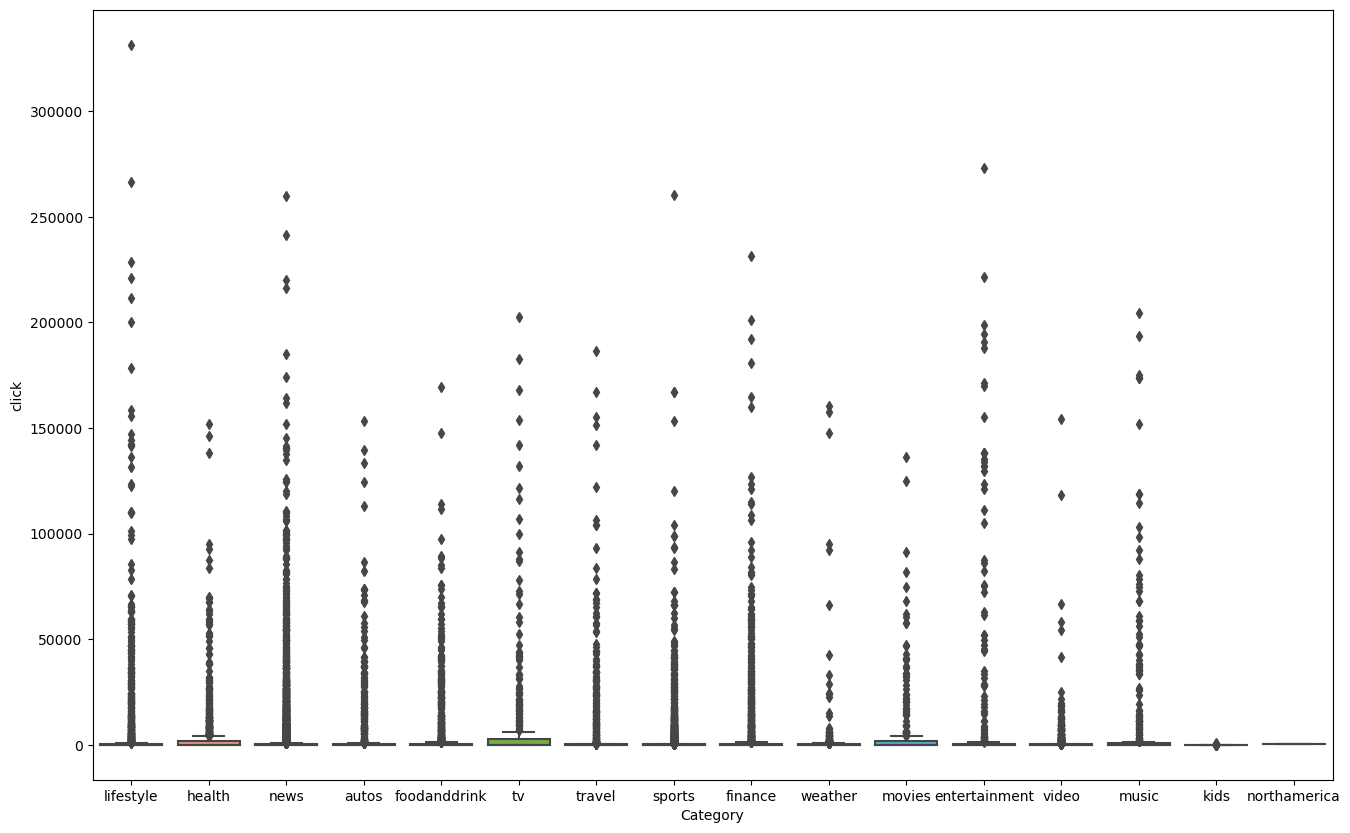

In [4]:
# カテゴリごとのPV数分布をプロット
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(x='Category', y='click', data=result)

かなり外れ値が多いデータであることが見て取れます。また、偏りが大きいのも見て取れます。

log を使用して正規化を試みます。

<Axes: xlabel='Category', ylabel='log_click'>

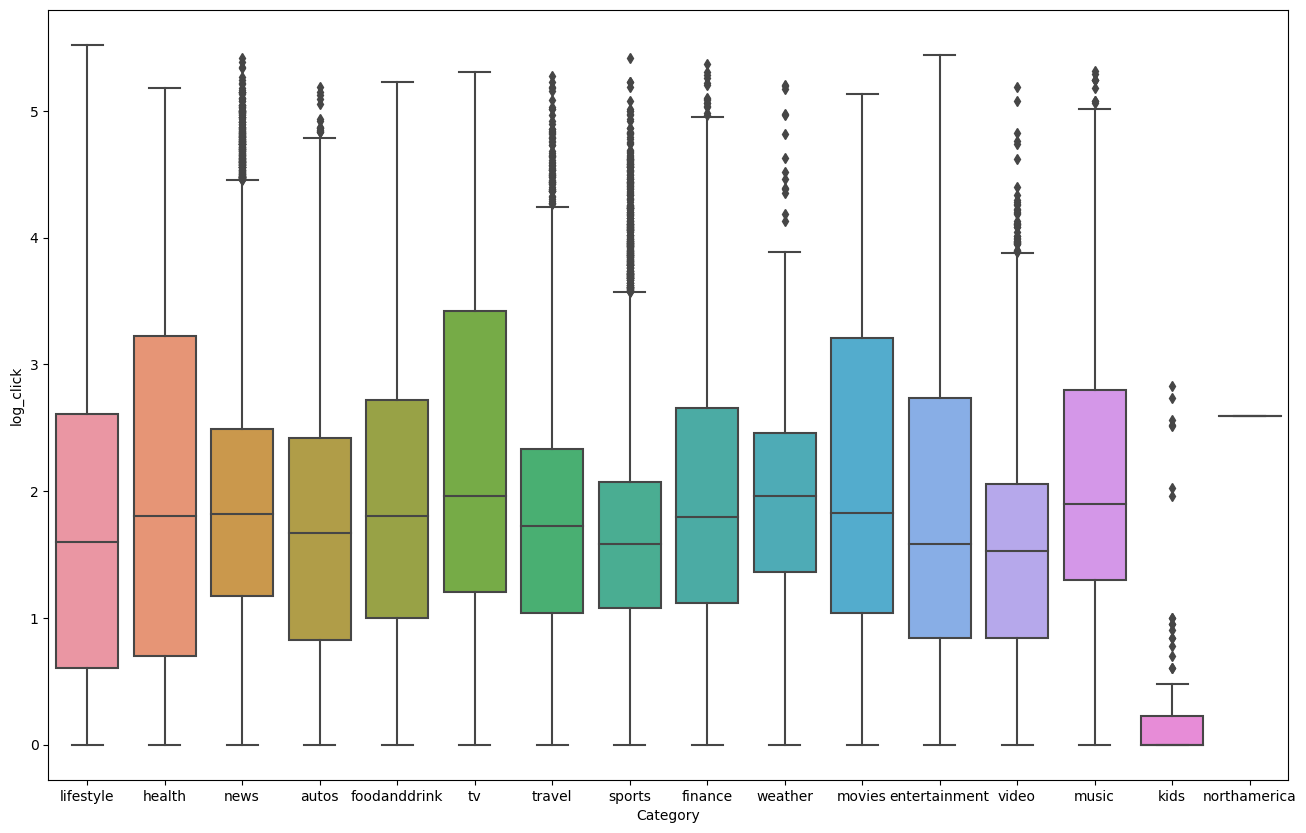

In [5]:
import numpy as np
result['log_click'] = np.log10(result['click'])
fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(x='Category', y='log_click', data=result)

<Axes: xlabel='log_click', ylabel='Count'>

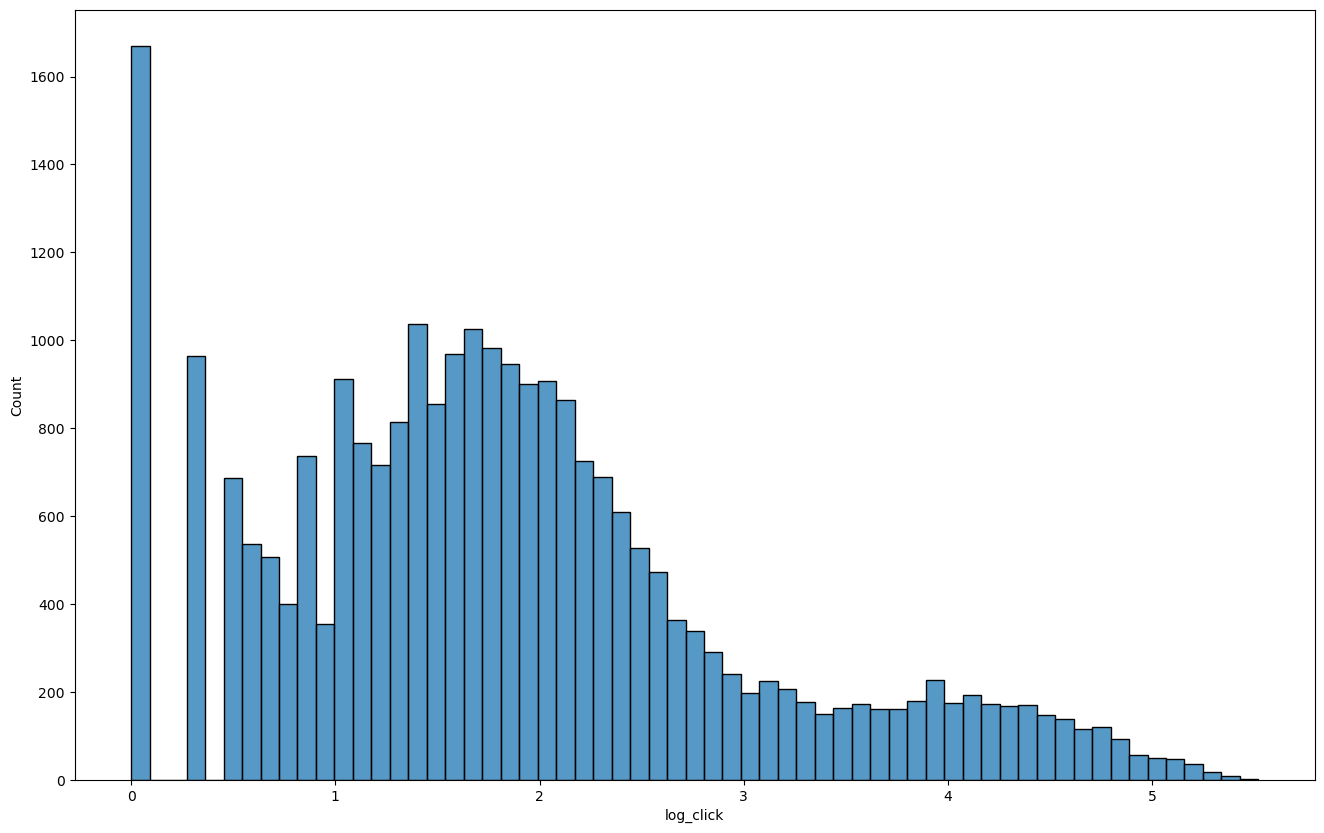

In [6]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.histplot(result["log_click"])

正規化した結果データの分布が均等になり外れ値も減り分析しやすいデータになりました。

ヒストグラムを見てみると正規分布に近いように見えますが、3つの正規分布が組み合わさっているようにも見えます。(Tri-Modal Distribution)

## PV 予測モデルの構築

今回はサンプルデータとして、オーソドックスな英語の BERT モデルの Embedding を利用して予測を行います。

日本語の場合は日本語で事前学習済みのモデルをいくつか比較検討して使うと良いでしょう。

In [7]:
!pip install transformers "accelerate>=0.20.3" datasets evaluate sentencepiece -q

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: xlabel='label', ylabel='Count'>

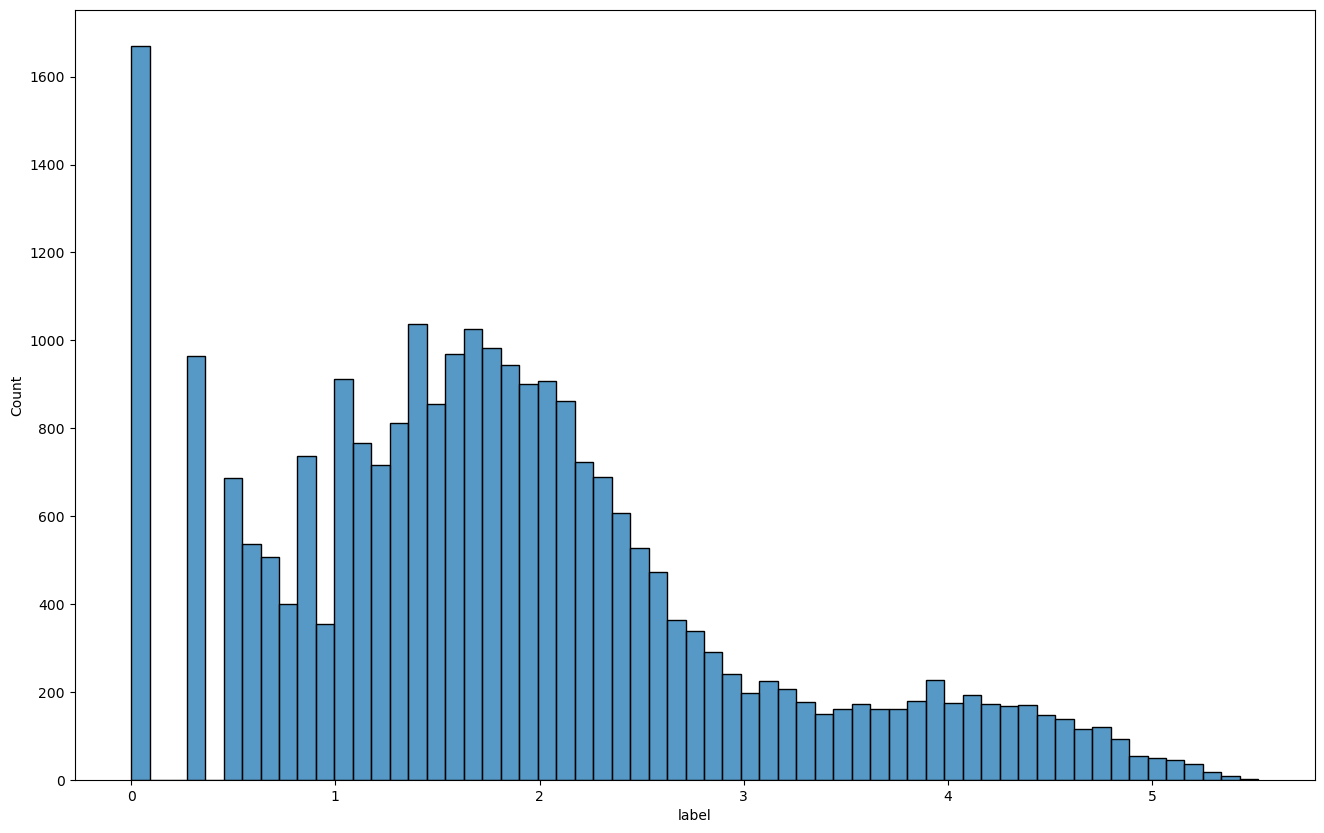

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import evaluate
import numpy as np
from datasets import Dataset
from scipy.stats import zscore

result["label"] = result[["log_click"]]

# 可視化
fig, ax = plt.subplots(figsize=(16, 10))
sns.histplot(result["label"])

In [9]:
datasets = Dataset.from_pandas(result)
datasets = datasets.shuffle().select(range(10000)).train_test_split(test_size=0.4)
datasets

DatasetDict({
    train: Dataset({
        features: ['News ID', 'Category', 'Subcategory', 'Title', 'Abstract', 'URL', 'click', 'log_click', 'label'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['News ID', 'Category', 'Subcategory', 'Title', 'Abstract', 'URL', 'click', 'log_click', 'label'],
        num_rows: 4000
    })
})

In [10]:
from transformers import AutoTokenizer

model_ckpt = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


MAX = 256

def tokenize(batch):
    enc =  tokenizer(batch["Title"], padding=True, truncation=True, max_length=MAX)
    return enc

column_names = datasets["train"].column_names
column_names.remove("label")

processed_datasets = datasets.map(tokenize, remove_columns=column_names)
print(processed_datasets)
print(processed_datasets["train"].features)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["test"]

Map: 100%|██████████| 4000/4000 [00:00<00:00, 4775.23 examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
})
{'label': Value(dtype='float64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [11]:
# モデルとトークナイザの定義
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 1

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

metric = evaluate.load("mae")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return metric.compute(predictions=predictions, references=labels)


batch_size = 128
logging_steps = len(train_dataset) // batch_size
model_name = "pv-regression-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=5,
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
)
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.14.326, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Mae
1,1.880500,1.257524,0.858294
2,1.283700,1.224098,0.855690
3,1.246400,1.228248,0.865011
4,1.186000,1.214444,0.858420
5,1.169900,1.221872,0.863874


TrainOutput(global_step=235, training_loss=1.3490393111046324, metrics={'train_runtime': 54.9331, 'train_samples_per_second': 546.119, 'train_steps_per_second': 4.278, 'total_flos': 504223143679200.0, 'train_loss': 1.3490393111046324, 'epoch': 5.0})

In [12]:
preds_output = trainer.predict(eval_dataset)

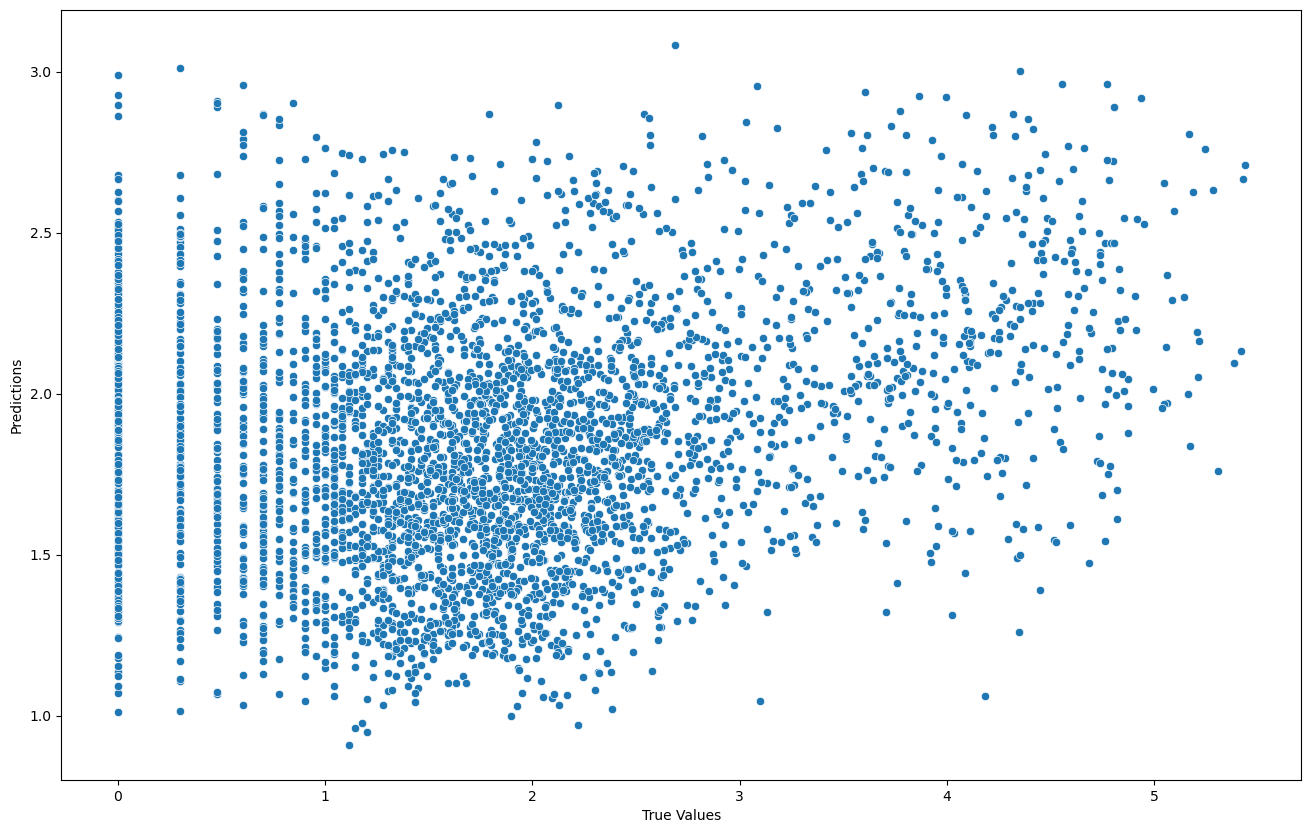

In [13]:
preds = preds_output.predictions.squeeze()
labels = preds_output.label_ids

fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(x=labels, y=preds)
sns.set(style="darkgrid")
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

実際のクリック数と予測を比較してみたところ、傾向として左、中央下、右上で3つのクラスタがあります。

右の二つのクラスタ（中央下、右上）はPV 数の少ない傾向の集まりと PV 数の多い傾向の集まりを表していることが観測されます。

一方で 1 以下の左は log10 なのでクリックが10以下のデータですが中央下のクラスタと比較して PV が高く予測されているものもあります。おそらく Microsoft News に掲載されていた期間やパーソナライズ等で表示された回数が少ないため実際のクリック率も少なかったと考えられます。この仮説については詳細はデータ分析してみて裏付けを得るべきでしょう。

MIND データセットでのタイトル単体でクリック予測を実行した場合、ある程度の傾向は読み取れるようです。

Microsoft News は画像を主体に見せる傾向があるので画像も予測に併用すればより精度が高くなる可能性はあります。